In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

load_dotenv()

cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom", [(0, "#db404c"), (0.5, "#ffffff"), (1, "#428195")]
)

In [2]:
import openai
import chromadb

client = openai.OpenAI(
    base_url="https://api.fireworks.ai/inference/v1",
    api_key=os.environ["fireworks"],
)

chroma_client = chromadb.PersistentClient("db/")
collection = chroma_client.get_or_create_collection(
    name="emotions_cosine", metadata={"hnsw:space": "cosine"}
)

In [14]:
definitions = {
    "admiration": "Finding something impressive or worthy of respect",
    "amusement": "Finding something funny or being entertained",
    "anger": "A strong feeling of displeasure or antagonism",
    "annoyance": "Mild anger, irritation",
    "approval": "Having or expressing a favorable opinion and seeing it's correct",
    "caring": "Displaying kindness and concern for others",
    "confusion": "Lack of understanding, uncertainty",
    "curiosity": "A strong desire to know or learn something",
    "desire": "A strong feeling of wanting something or wishing for something to happen",
    "disappointment": "Sadness or displeasure caused by the nonfulfillment of one’s hopes or expectations",
    "disapproval": "Disagreement. Arguing and disapproval with opinion and seeing it a pure shit",
    "disgust": "Revulsion or strong disapproval aroused by something unpleasant or offensive",
    "embarrassment": "Self-consciousness, shame, or awkwardness",
    "excitement": "Feeling of great enthusiasm and eagerness",
    "fear": "Being afraid or worried",
    "gratitude": "A feeling of thankfulness and appreciation",
    "grief": "Intense sorrow, especially caused by someone’s death",
    "joy": "A feeling of pleasure and happiness",
    "love": "A strong positive emotion of regard and affection",
    "nervousness": "Apprehension, worry, anxiety",
    "optimism": "Hopefulness and confidence about the future or the success of something",
    "pride": "Pleasure or satisfaction due to ones own or the achievements of those with whom one is closely associated",
    "realization": "Becoming aware of something",
    "relief": "Reassurance and relaxation following release from anxiety or distress",
    "remorse": "Regret or guilty feeling",
    "sadness": "Emotional pain, sorrow",
    "surprise": "Feeling astonished, startled by something unexpected",
}
emotions = [
    "amusement",
    "excitement",
    "joy",
    "love",
    "desire",
    "optimism",
    "caring",
    "pride",
    "admiration",
    "gratitude",
    "relief",
    "approval",
    "realization",
    "surprise",
    "curiosity",
    "confusion",
    "fear",
    "nervousness",
    "remorse",
    "embarrassment",
    "disappointment",
    "sadness",
    "grief",
    "disgust",
    "anger",
    "annoyance",
    "disapproval",
]
id2label = {str(id): label for id, label in enumerate(emotions)}
label2id = {v: k for k, v in id2label.items()}

In [15]:
def get_embeddings(text):
    response = client.embeddings.create(
        model="thenlper/gte-large",
        input=f"{text}",
    )
    return response.data[0].embedding

In [16]:
for emotion in emotions:
    embedding = get_embeddings(definitions[emotion])
    collection.upsert(
        ids=label2id[emotion],
        embeddings=embedding,
    )

In [17]:
distances_embed = np.zeros((len(emotions), len(emotions)))
counter = 0
for emotion in emotions:
    embedding = collection.get(ids=label2id[emotion], include=["embeddings"])[
        "embeddings"
    ][0]
    result = collection.query(
        embedding, n_results=27, include=["distances", "documents"]
    )
    ids = result["ids"][0]
    indexes = [(pos, int(idx)) for pos, idx in enumerate(ids)]
    distances_inorder = []
    for i in range(len(indexes)):
        pos_in_order = list(filter(lambda x: x[1] == i, indexes))[0][0]
        distances_inorder.append(result["distances"][0][pos_in_order])
    distances_embed[counter] = np.round(np.array([distances_inorder]), 2)
    counter += 1

In [18]:
average = (distances_embed.min() + distances_embed.max()) / 2
np.fill_diagonal(distances_embed, average)
distances_embed = (distances_embed - distances_embed.min()) / (
    distances_embed.max() - distances_embed.min()
)
np.fill_diagonal(distances_embed, 0.5)

In [19]:
distances_embed.min()

0.0

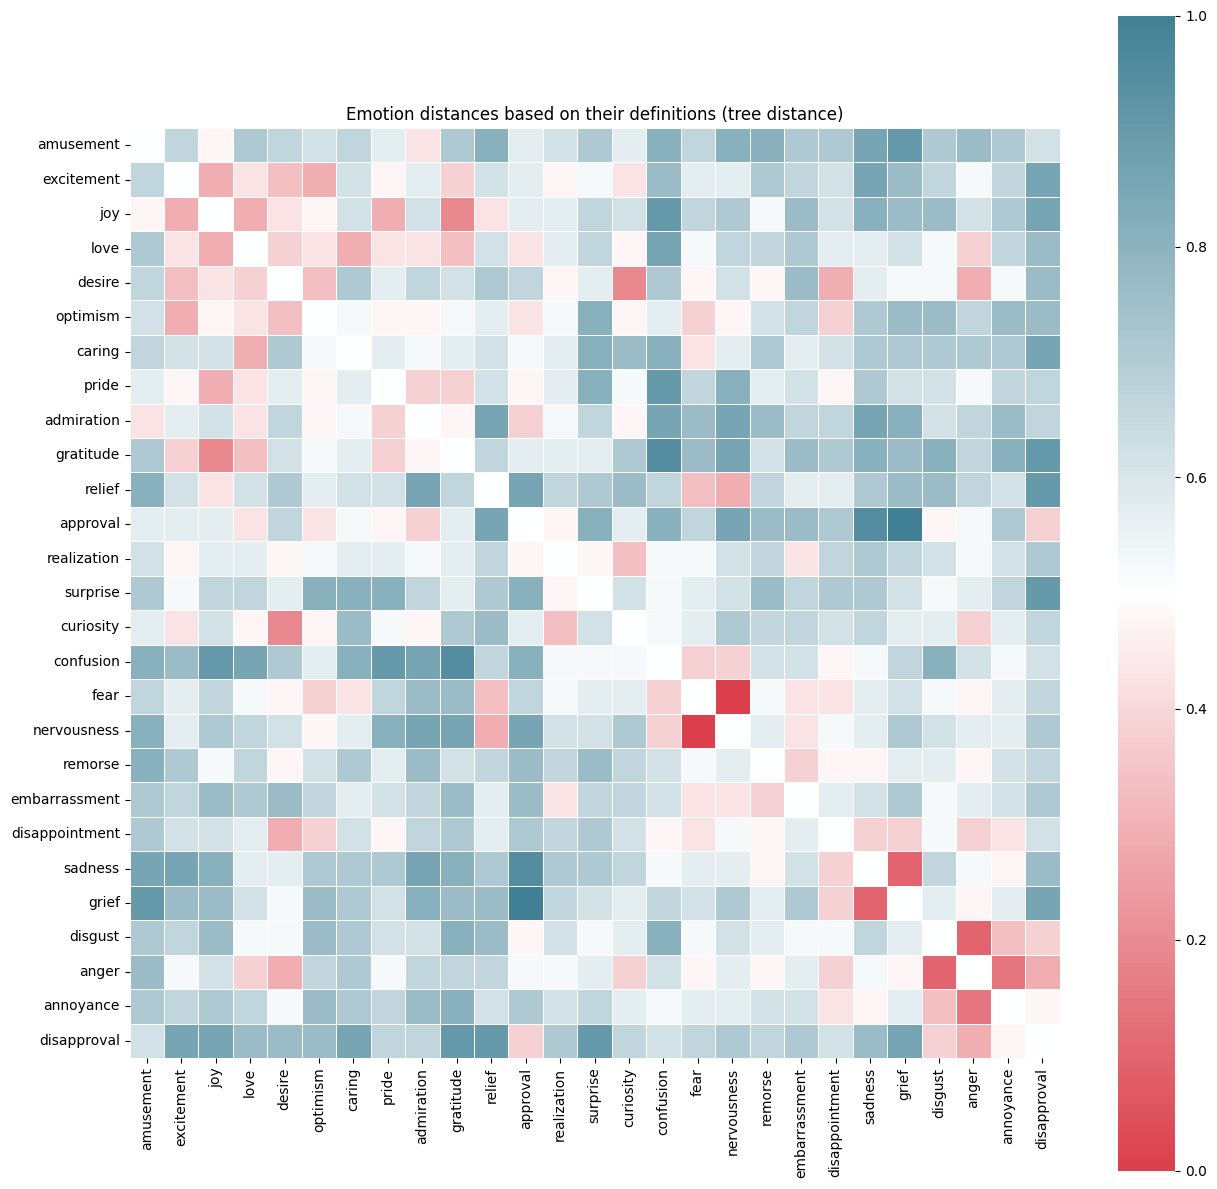

In [20]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    distances_embed,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (tree distance)")
plt.show()

# Distance based on emotions tree

In [21]:
from emotion_tree import get_distance

In [22]:
distances_tree = np.zeros((len(emotions), len(emotions)))
for i, emotion1 in enumerate(emotions):
    for j, emotion2 in enumerate(emotions):
        distances_tree[i, j] = get_distance([emotion1], [emotion2])

distances_tree[distances_tree < 0] = 0.5

In [23]:
import matplotlib as mpl
import seaborn as sns


cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "custom", [(0, "#db404c"), (0.5, "#ffffff"), (1, "#428195")]
)

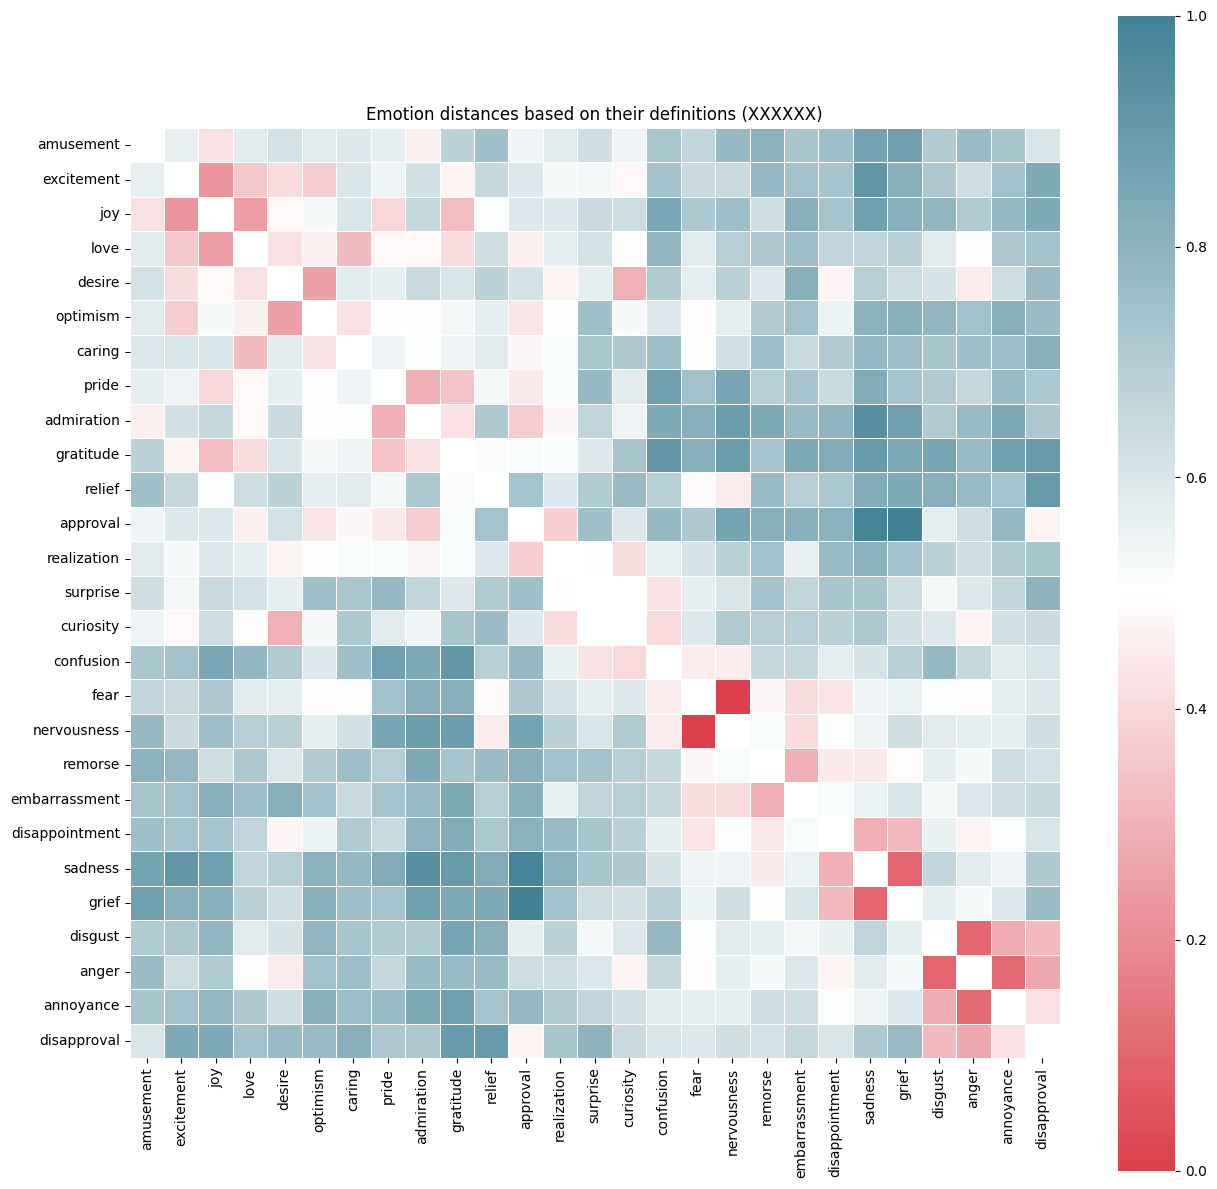

In [52]:
plt.figure(figsize=(15, 15))
beta = 0.3
combined = (distances_tree * beta) + (distances_embed * (1 - beta))
combined = (combined - combined.min()) / (combined.max() - combined.min())
np.fill_diagonal(combined, 0.5)
sns.heatmap(
    combined,
    cmap=cmap,
    square=True,
    xticklabels=list(emotions),
    yticklabels=list(emotions),
    linewidths=0.5,
)
plt.xticks(rotation=90)
plt.title("Emotion distances based on their definitions (XXXXXX)")
plt.show()